# Machine Learning and Computational Statistics - Project

This project is devoted to Hypespectral Images (HSI) processing

---
> Vasileios Galanos <br />
> Msc in Data Science (Part-Time) <br />
> 3/2020 <br />
> vgalanos@aueb.gr
---
## Introduction -  Exploring the data

First we import the data from the `.mat` files into arrays. Specifically:
* The `300x200` spatial resolution HSI with `103` spectral bands from the file `PaviaU_cube.mat` is loaded into the array `HSI`
* The `9` endmembers (spectral signatures for pure elements) from the file `PaviaU_endmembers.mat` is loaded into `endmembers`
* The information of the class label for each pixel from the file `PaviaU_ground_truth.mat` is loaded into `labels`

We then plot the endmembers' spectral signatures along the 103 spectral bands and we also plot a the RGB image of the HSI at the 10th band

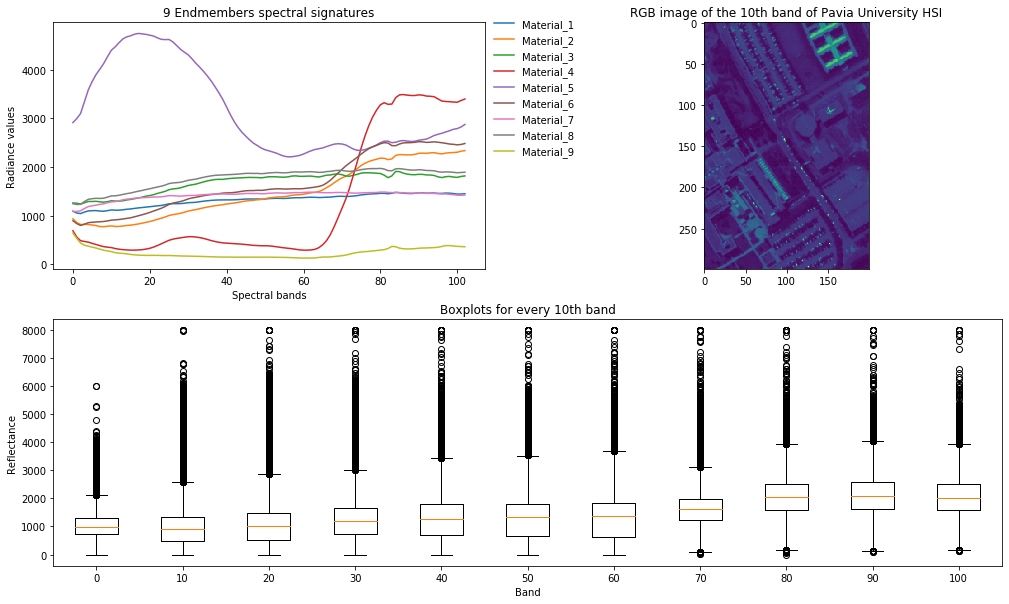

In [2]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt

# HSI import
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

# endmembers import
ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']

# ground truth import
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

endmembers_names =  ['Material_'+str(i+1) for i in range(9)]

# plot figures
fig = plt.figure(figsize=(17,10))

ax = fig.add_subplot(2,2,1)
ax.plot(endmembers)
#ax.legend(list(endmembers_dict.values()),bbox_to_anchor=(1.0, 1.05),framealpha=0)
ax.legend(endmembers_names,bbox_to_anchor=(1.0, 1.05),framealpha=0)
ax.set_ylabel('Radiance values')
ax.set_xlabel('Spectral bands')
ax.set_title('9 Endmembers spectral signatures')

ax = fig.add_subplot(2,2,2)
ax.imshow(HSI[:,:,10])
ax.set_title('RGB image of the 10th band of Pavia University HSI')

ax = fig.add_subplot(2,1,2)
ax.set_title('Boxplots for every 10th band')
bands_sample = np.arange(103,step = 10)
ax.boxplot([HSI[:,:,i].flatten() for i in bands_sample])
ax.set_ylabel('Reflectance')
ax.set_xlabel('Band')
ax.set_xticklabels(bands_sample)
plt.show()

## Part 1 -  Spectral Unmixing
---
### (A) - Abundance maps and Reconstruction errors
In this part, we will perform unmixing on each of of the pixels in the image with nonzero label, with respect to 9 endmembers. Specifically:
* We adopt the linear spectral unmixing hypothesis

$$
y = X\theta + \eta
$$

, where $y$ is the `103-dim.` spectral signature of the pixel under study, $X$ is the `103x9` matrix with the spectral signatures for each pure element (endmember), $\theta$ is the `9-dim.` abundance vector of the pixel and $\eta$ is the noise.

### (a) Unconstrained Least Squares
Given a matrix $X$ and a vector $y$ the least squares solver finds a solution for the following problem

$$
\text{arg min}_\theta = || X\theta - y ||^2
$$

The parameter vector $\theta$ is estimated directly using the [Scipy implementation of the Least Squares Solver](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html)

$$
\hat{\theta} = (X^TX)^{-1}X^Ty
$$

This solution is optimal with respect to the Mean Squared Error.

* After the estimation of $\theta$ for all the pixels, we will plot the 9 abundance maps.
* We also define a reconstruction error for our spectral unmixing (for each non-zero labels) as 

$$
\frac{1}{N} \sum_{i=1}^N||y_i - X\theta_i ||^2 
$$

, where $N$ is the total number of pixels with non-zero labels.

Reconstruction Error - LS Simple: 118783.181


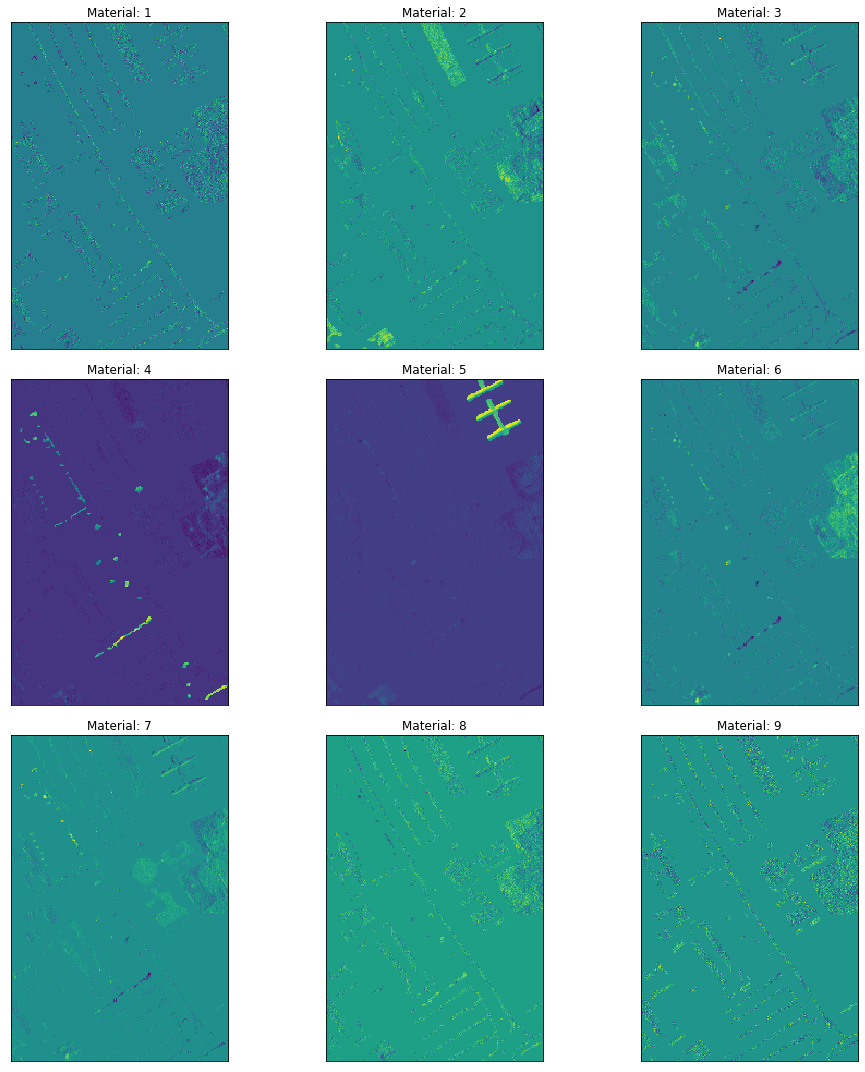

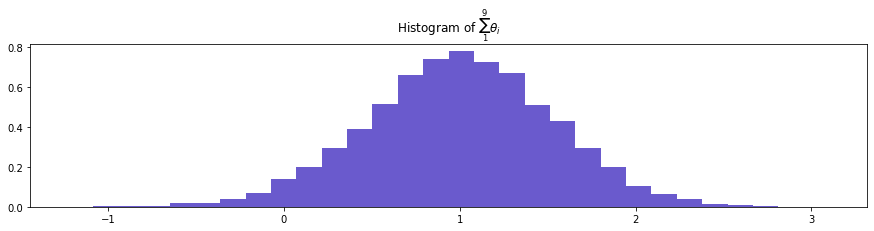

In [5]:
# least squares solver, simple case
def ls_simple(image, endmembers, labels):
    theta = np.zeros((image.shape[0],image.shape[1],endmembers.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                theta[i][j] = np.linalg.lstsq(endmembers, image[i][j],rcond=None)[0]
    return theta

# Function for plotting abundance maps
def plot_abundance_maps(theta_matrix):    
    fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.001)

    axs = axs.ravel()
    for i in range(9):
        axs[i].imshow(theta_matrix[:,:,i])
        axs[i].set_title('Material: '+str(i+1))
        axs[i].grid(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.tight_layout()
        
def reconstruction_error(image, endmembers, labels, theta):
    
    sum_error = 0
    count = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                sum_error += np.sum(np.power(image[i,j,:] - np.dot(endmembers, theta[i,j,:]) ,2))
                count +=1
                
    return np.round(sum_error/count,3)

def plot_hist_par(theta_matrix, labels,bin_num, cust_range):
    # plot Histogram
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    ax.hist(np.sum(theta_matrix,axis=2)[labels != 0]
            ,density=True
            ,color='slateblue'
            ,bins=bin_num
            ,range=cust_range)
    ax.set_title('Histogram of $\sum_1^9 \\theta_i$')

    plt.show()

theta_simple = ls_simple(HSI, endmembers, labels)
plot_abundance_maps(theta_simple)
print('Reconstruction Error - LS Simple:', reconstruction_error(HSI,endmembers, labels, theta_simple))
plot_hist_par(theta_simple, labels,30,None)

### (b) Non-negative Least Squares

The problem that we are trying to solve here is a constrained least squares problem expressed as

$$
\text{arg min}_\theta = || X\theta - y ||^2, \quad \quad \text{subject to } x \geq 0
$$

This problem cannot be solved directly as before. Instead, an iterative algorithm is utilized:
[Scipy implementation for the Non Negative LS Solver](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls)


Reconstruction Error - Non Negative LS:  569339.291


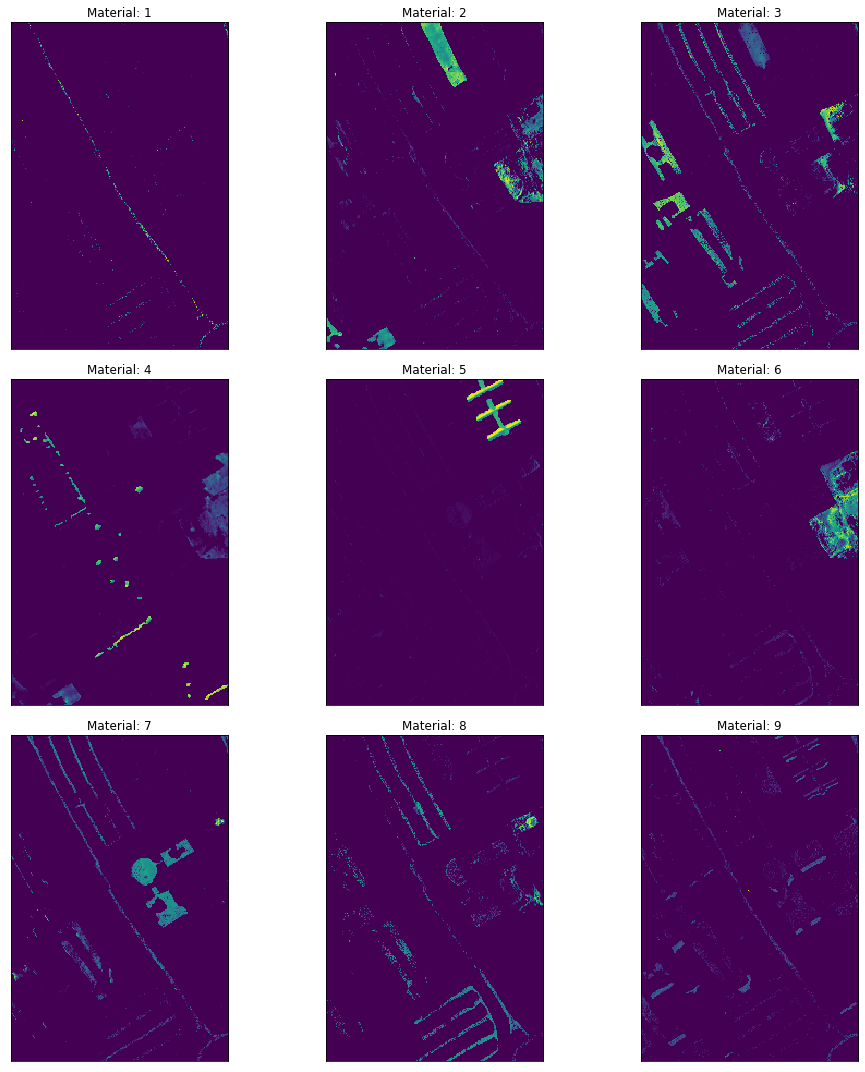

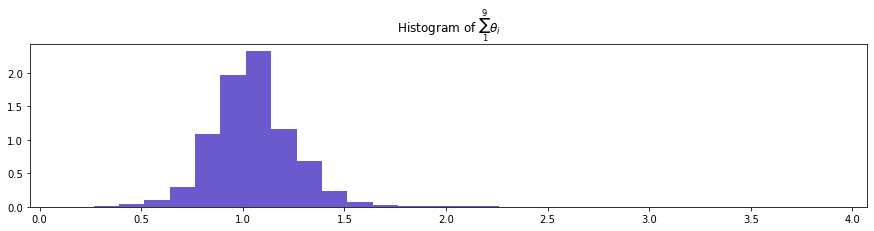

In [7]:
def ls_nn(image, endmembers, labels):
    theta = np.zeros((image.shape[0],image.shape[1],endmembers.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                theta[i][j] = scipy.optimize.nnls(endmembers, image[i][j])[0]
    return theta

theta_nn = ls_nn(HSI, endmembers, labels)
plot_abundance_maps(theta_nn)
print('Reconstruction Error - Non Negative LS: ', reconstruction_error(HSI,endmembers, labels, theta_nn))
plot_hist_par(theta_nn, labels,30,None)

### (c) Sum to One Least Squares

The problem that we are trying to solve here is a constrained least squares problem expressed as

$$
\text{arg min}_\theta = || X\theta - y ||^2, \quad \quad \text{subject to } \sum_{i=1}^l \theta_i =1
$$

Instead of using an iterative algorithm to try to solve the problem like the previous case, we can just include the contraint in the data, in order to utilize the LS estimator like the unconstrained case. In order to do that we make the following transformation to the data sets:

* $X = \begin{bmatrix} X \\ 1 \end{bmatrix}$, where __1__ is a 9-dim vector of ones. X is now a `104x9` matrix
* $y = \begin{bmatrix} y \\ 1 \end{bmatrix}$, where we just append the scalar 1 at the bottom of the y vector
* Thus, we added one more equation to the LS solver: 
$1 = [1,1,\dots,1]   \begin{bmatrix} \theta_1 \\ \vdots \\ \theta_9 \end{bmatrix}$
* But in that way, we just added one more equation to the previous 103. We need to add some weight, in order to impose the significance of this particular equation compared to the others. We need to perform a __Weighted Least Squares Estimation__:

$$
\hat{\theta} = (X^TWX)^{-1}X^TWy,\quad \quad \text{where } 
W = \begin{bmatrix} 
w_{11} & 0 & \dots & 0 \\ 
0 & w_{22} & \dots & 0 \\ 
\vdots & \vdots & \ddots & \vdots \\ 
0 & 0 & \dots & w_{104,104} 
\end{bmatrix}
$$

* We found that the best reconstruction error, along with a good satisfaction of the sum to one constrained is achieved for

$$ 
w_{11} = w_{22} = \dots = w_{103,103}=1,\quad \text{and } w_{104,104} = 6\times std\{ X \} \approx 5348.840
$$

Reconstruction Error - LS Simple: 159627.63


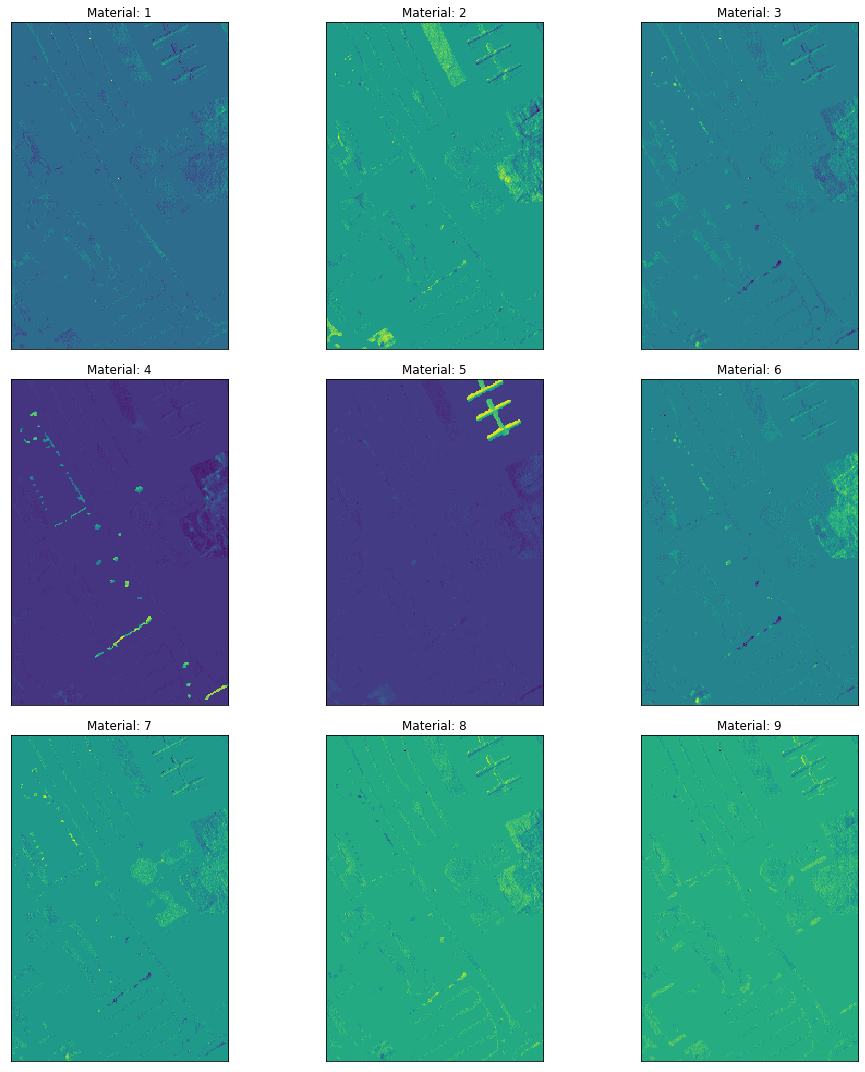

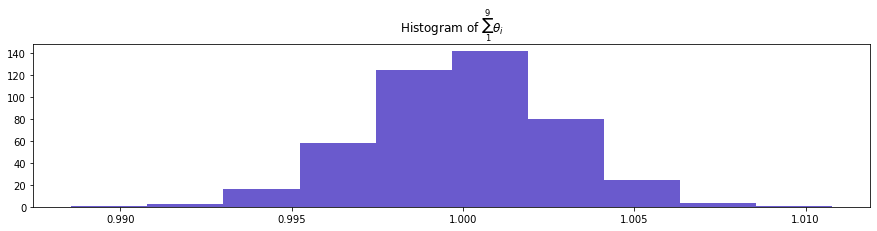

In [8]:
# Weighted Least Squares
def ls_weighted(image, endmembers, labels, Weights):
    theta = np.zeros((image.shape[0],image.shape[1],endmembers.shape[1]))
    endmembers_w = np.vstack((endmembers, np.ones(endmembers.shape[1])))
    endmembers_w = np.dot(Weights,endmembers_w)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                image_w = np.append(image[i][j],[1])
                image_w = np.dot(image_w,Weights)
                theta[i][j] = np.linalg.lstsq(endmembers_w,image_w ,rcond=None)[0]
    return theta

# define Weight matrix
W = np.eye(104,104)
W[-1] = W[-1]*6*np.sqrt(np.var(HSI))

theta_sum1_w = ls_weighted(HSI, endmembers, labels,W)
plot_abundance_maps(theta_sum1_w)
print('Reconstruction Error - LS Simple:', reconstruction_error(HSI,endmembers, labels, theta_sum1_w))
plot_hist_par(theta_sum1_w, labels,10, None)

### (d) Sum to One & Non Negative Least Squares

The problem that we are trying to solve here is a constrained least squares problem expressed as

$$
\text{arg min}_\theta = || X\theta - y ||^2, \quad \quad \text{subject to } x \geq 0 \text{ and } \sum_{i=1}^l \theta_i =1
$$

This problem cannot be solved directly as before. Instead, an iterative algorithm is used in order to minimize a function with constrains:
[Scipy Optimze Minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

* Our initial guess for the minimization algorithm is $\theta = [\frac{1}{9},\frac{1}{9},\dots,\frac{1}{9}]^T$ (we also used the unconstrained least squares estimate as an initial guess but it scored a worse reconstruction error)

Reconstruction Error - Sum to One & Non Negative LS:  4535359.744


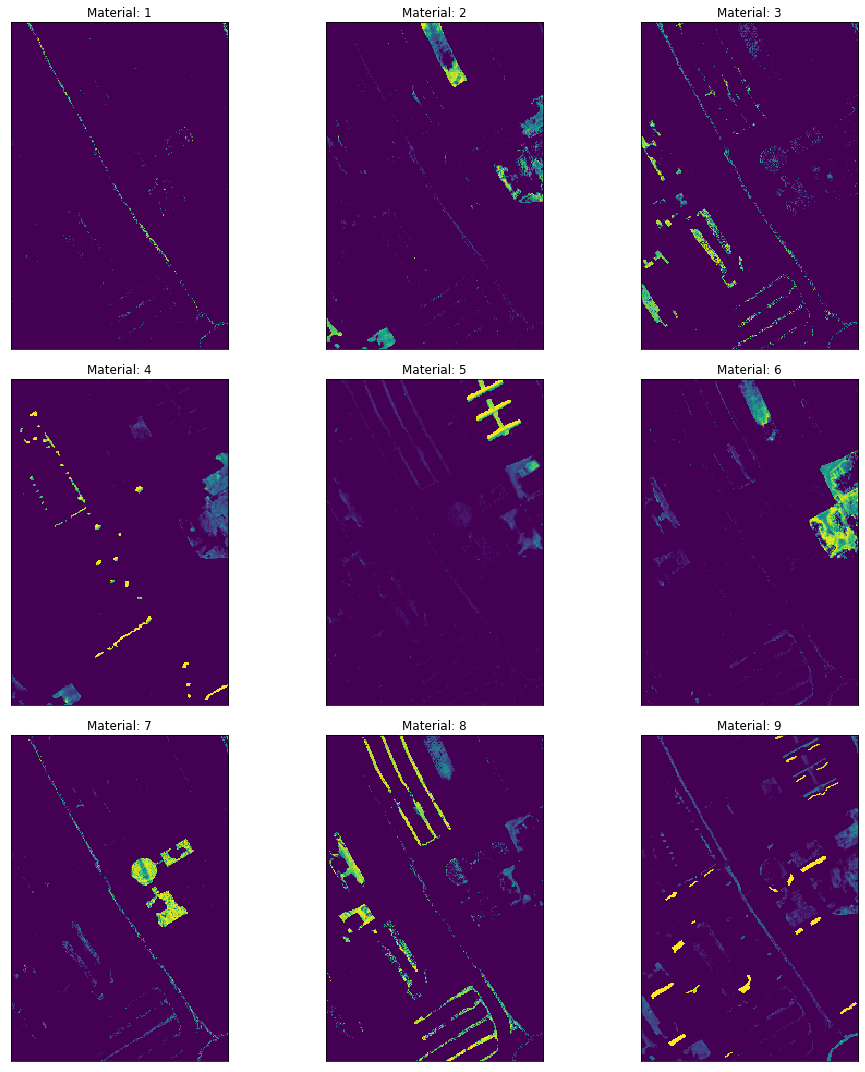

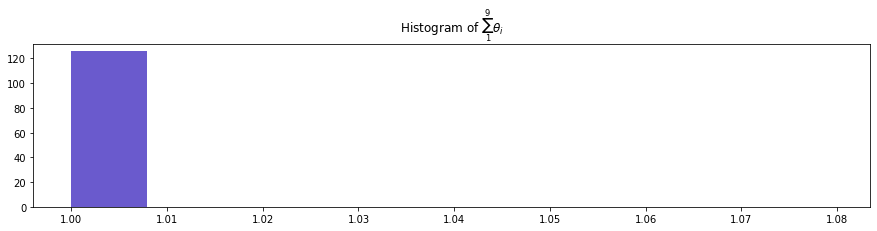

In [10]:
from scipy import optimize

def obj_fun(x, b, A):
    return np.linalg.norm(A.dot(x) - b)

def constraint_ls_nn(y,X):
    p0 = np.zeros(X.shape[1]) + 1/X.shape[1]
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    bnds = [[0,None]]*X.shape[1]
    res = optimize.minimize(
        obj_fun, p0, args=(y, X),
        bounds=bnds,
        method='SLSQP', constraints=cons)
    return res.x

def ls_sum1_nn(image, endmembers, labels):
    theta = np.zeros((image.shape[0],image.shape[1],endmembers.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                theta[i][j] = constraint_ls_nn(image[i][j],endmembers)
    return theta

theta_sum1_nn = ls_sum1_nn(HSI, endmembers, labels)
plot_abundance_maps(theta_sum1_nn)
print('Reconstruction Error - Sum to One & Non Negative LS: ', reconstruction_error(HSI,endmembers, labels, theta_sum1_nn))
plot_hist_par(theta_sum1_nn, labels, 10, None)

### (e) LASSO

The problem that we are trying to solve here is a regularized least squares problem expressed as

$$
\text{arg min}_\theta = || X\theta - y ||^2, \quad \quad \text{subject to } || \theta ||_1 \leq \rho
$$

This task is reformulated equivalently as

$$
\text{arg min}_\theta = || X \theta - y ||^2 + \lambda ||\theta ||_1
$$

We will use [Linear Model trained with L1 prior as a regularizer](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).
* We found that the best results are achieved for the Lagrangian term $\lambda = 35$

Reconstruction Error - Sum to One & Non Negative LS:  152840.586


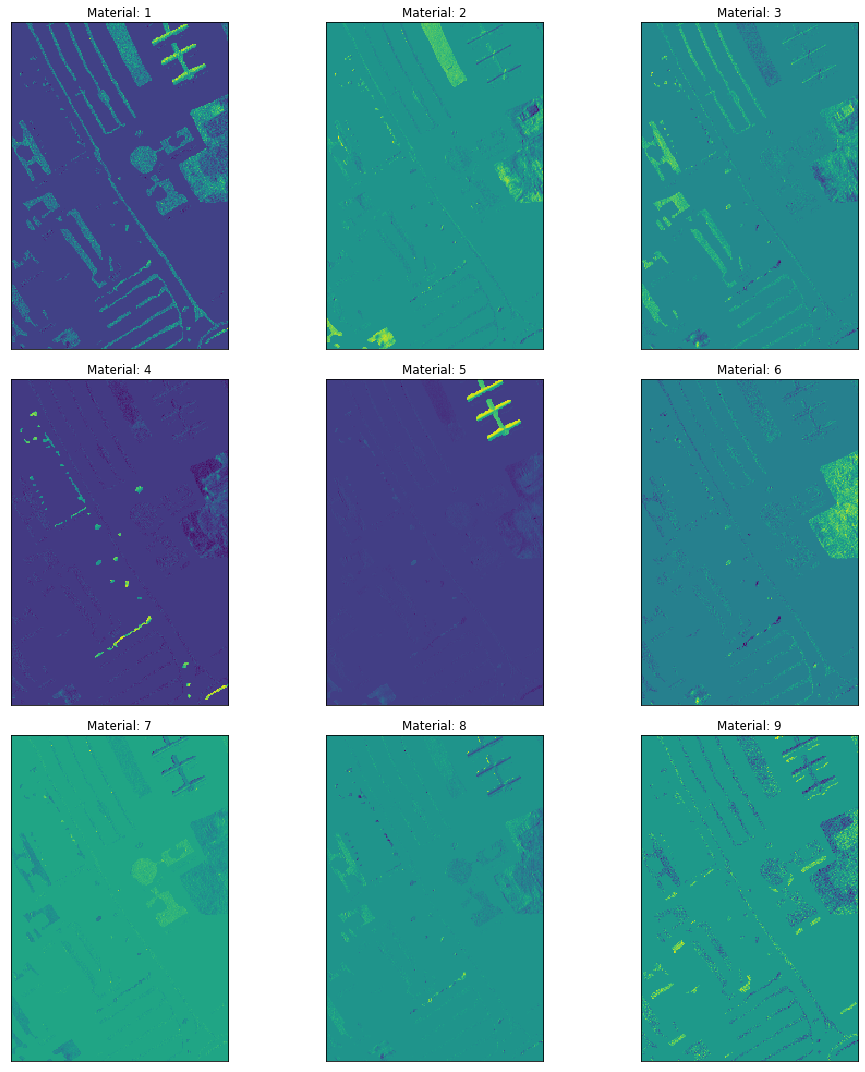

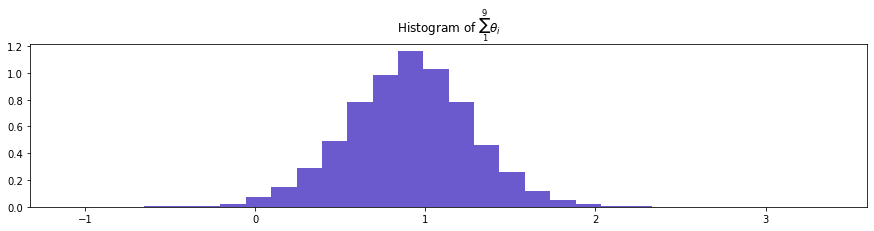

In [11]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

def ls_lasso(image, endmembers, labels, alpha):
    theta = np.zeros((image.shape[0],image.shape[1],endmembers.shape[1]))
    clf = linear_model.Lasso(alpha=alpha
                         ,max_iter=10000
                         ,positive=False
                         ,tol=0.00001
                         ,fit_intercept=False    
                         ,normalize=False
                        )
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i][j] != 0:
                clf.fit(endmembers,image[i][j]) 
                theta[i][j] = clf.coef_
    return theta

lamda = 35  
theta_lasso = ls_lasso(HSI, endmembers, labels, lamda)
plot_abundance_maps(theta_lasso)
print('Reconstruction Error - Sum to One & Non Negative LS: '
          , reconstruction_error(HSI,endmembers, labels, theta_lasso))
plot_hist_par(theta_lasso, labels, 30 , None)

### (B) - Comparison

Comparing the results obtained from the above five methods, the unconstrained LS method (a) had the smallest __reconstruction error__, while the full constrained LS estimator (d) scored the worse. 

* It seems that the spectral unmixing did not performed well for the cases where we we oppose an inequality constraint. That is logical, if we consider the fact that inequality constraints are much more difficult to solve than equality constraints as a minimization problem.

* The results for the case with the sum to one contraint were very good. We managed to get close to the optimal reconstruction error (unconstrained LS-case) and also have the majority of the parameter vectors sum to one (thus representing true abundance of each material).

We can visualize the difference in the reconstruction errors below:


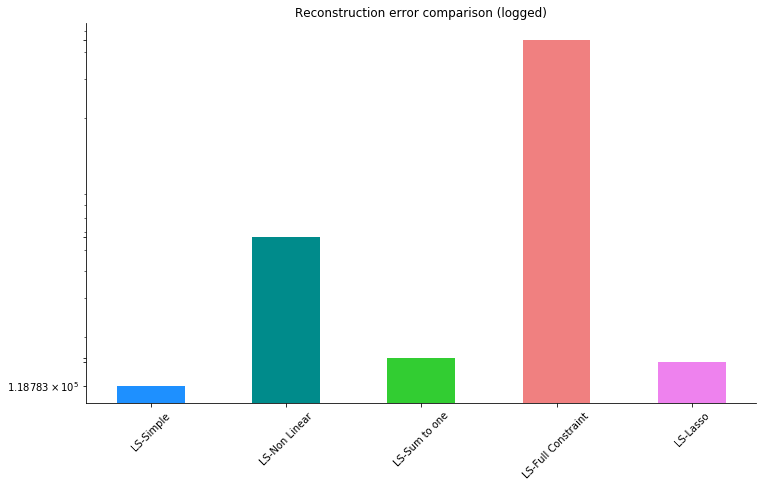

In [13]:
colors = ['dodgerblue','darkcyan','limegreen','lightcoral','violet']

top=[ ('LS-Simple',reconstruction_error(HSI, endmembers, labels, theta_simple))
     ,('LS-Non Linear',reconstruction_error(HSI, endmembers, labels, theta_nn))
     ,('LS-Sum to one',reconstruction_error(HSI, endmembers, labels, theta_sum1_w))
     ,('LS-Full Constraint',reconstruction_error(HSI, endmembers, labels, theta_sum1_nn))
     ,('LS-Lasso',reconstruction_error(HSI, endmembers, labels, theta_lasso))
    ]

lab, ys = zip(*top)
xs = np.arange(len(lab)) 
width = 0.5

fig = plt.figure(figsize=(12,7))                                                               
ax = fig.add_subplot(111)

ax.bar(xs, ys, width, align='center', color=colors)
ax.set_yscale('log')
ax.set_title('Reconstruction error comparison (logged)')
ax.set_xticks(xs)
ax.set_xticklabels(lab, rotation=45)
ax.set_yticks(ys)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Comparing the __abundance maps__, we see that in almost all cases we achieved a fair unmixing.
* The abundance maps appear to represent purely each material and we can easily distinguish one from the other.
* Also compared to the `ground truth`, they appear to represent the correct pure materials
* An interesting result is that the abundance maps obtained from the non-negative constraint method (b) and the full constraint method (d) were visually closest to the ground truth, compared to the others, even though these methods had the worse reconstruction errors from all the methods.
* The materials that were not unmixed well were: `Material 3 and 8`
* The materials that were unmixed really well were: `Material 4,5 and 6`
* For all the others, the unmixing was acceptable but not perfect
* The Lasso method, failed completeley in unmixing `Material 1`, when all the others performed a lot better

We can see the visual representation for all the methods and materials compared to the ground truth (first row) below:

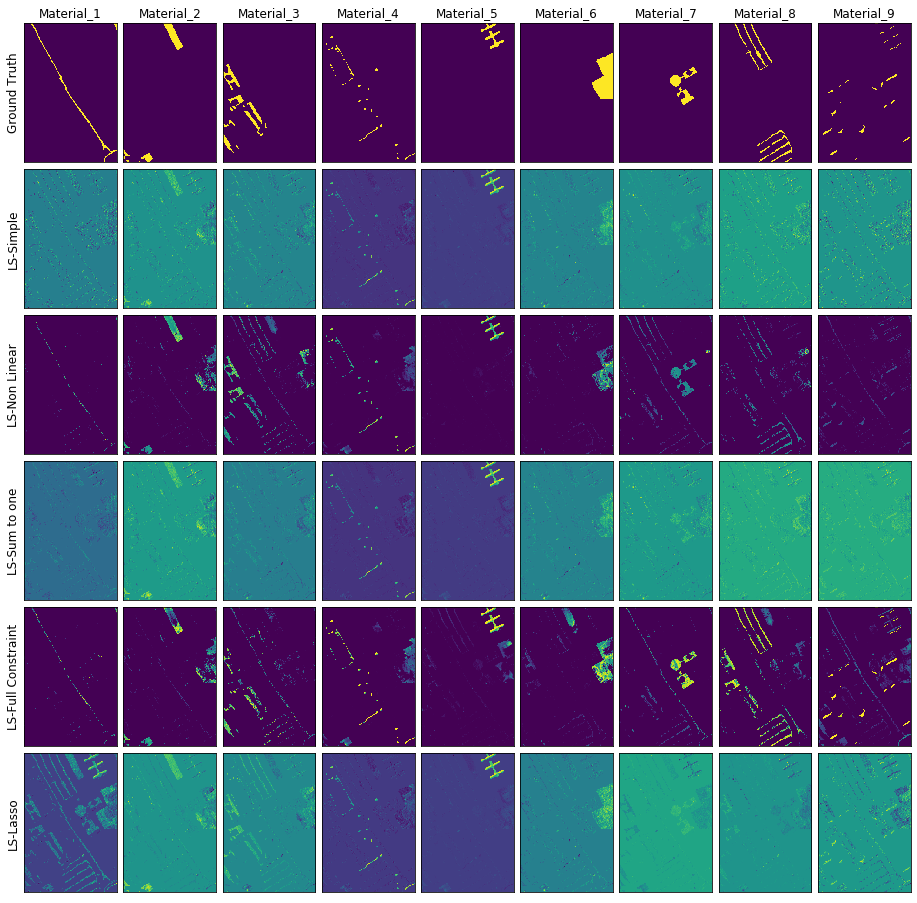

In [14]:
abund_names=['Ground Truth','LS-Simple','LS-Non Linear','LS-Sum to one','LS-Full Constraint','LS-Lasso']

fig, axs = plt.subplots(6,9, figsize=(16, 16), facecolor='w', edgecolor='k', sharex='col', sharey='row')
fig.subplots_adjust(hspace = .3, wspace=.001)

for i in range(9):
    axs[0,i].imshow(labels==i+1)
    axs[1,i].imshow(theta_simple[:,:,i])
    axs[2,i].imshow(theta_nn[:,:,i])
    axs[3,i].imshow(theta_sum1_w[:,:,i])
    axs[4,i].imshow(theta_sum1_nn[:,:,i])
    axs[5,i].imshow(theta_lasso[:,:,i])
    
for i in range(9):
    for j in range(6):
        if j==0:
            axs[j,i].set_title(endmembers_names[i], rotation=0, size='large')
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        if i==0:
            axs[j,i].set_ylabel(abund_names[j], rotation=90, size='large')
plt.subplots_adjust(wspace=0, hspace=0.05)

## Part 2 -  Classification
---
In this part, we consider only the image pixels with non-zero class label. Our goal is to assign each one of them to the most appropriate class, among the 9 known classes. We will use:
* the __Naive Bayes classifier__
* the __Minimum Euclidean distance classifier__
* the __k-nearest neighbor classifier__
* the __Bayesian classifier__

### (A) Training & Evaluation
For each classifier, the error metric that will be used is $Error = 1 - Accuracy = 1 - \frac{\text{Number of correct predictions}}{\text{Number of total predictions}}$

In __(i)__ we will train each classifier on the training set performing 10-fold cross-validation and report the estimated validation error as the mean of the ten resulting error values, along with the standard deviation.

In __(ii)__ the whole training set will be used to train each classifier, and their performance will be evaluated on the test set as follows: 
* We will compute the confusion matrix whose $(i,j)$ element is the number of pixels that belong to the i-class and are assigned from the classifier to the j-th class. We will comment on the diagonality of the matrix and on any particular classes that may not be seperated well by the corresponding classifier.
* We will compute the success rate of the classifier as the sum of the diagonal elements of the confusion matrix divided by the sum of all elements of the matrix. That is $\text{Success Rate} = \frac{1}{N}\sum_{i=1}^9 C_{ii}$

We obtain the __training__, __test__ and __operation__ sets and visualize them in the following figure.
The three sets are non-overlapping subsets of the same `ground truth` file thus $\text{Training} \cup \text{Test} \cup \text{Operational} = \text{Ground Truth}$

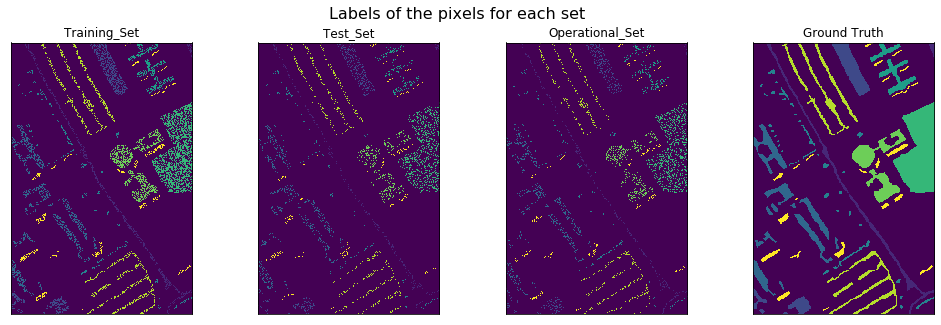

In [15]:
# Data sets
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig, axs = plt.subplots(1, 4, figsize=(17, 5), sharey=True)
fig.suptitle('Labels of the pixels for each set', fontsize=16)
axs[0].imshow(Training_Set)
axs[0].set_title('Training_Set')
axs[0].set_xticks([])

axs[1].imshow(Test_Set)
axs[1].set_title('Test_Set')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(Operational_Set)
axs[2].set_title('Operational_Set')
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow(labels)
axs[3].set_title('Ground Truth')
axs[3].set_xticks([])
axs[3].set_yticks([])
plt.show()

### Naive Bayes Classifier
__(i)__ 
This classifier (a special case of the Bayes classifier) makes the assumption that all the features are statistically indepedent, from each other. Thus 
$p(x | \omega_j) = \prod_{k=1}^lp_k(x_k |\omega_j),j=1,\dots,M$. This is very convenient and reduces the amount of operations required to estimate the corresponding pdf for each class. 
* The classifier estimates the a-priori probabilities as $P(\omega_j) \approx \frac{N_j}{N}$
* Defines, $g_j(x) = P(\omega_j)p(x|\omega_j) = P(\omega_j)\prod_{k=1}^lp_k(x_k |\omega_j)$
* and assigns $x$ to class $q$ with $g_q(x) = argmax_{j=1,\dots,M}g_j(x)$

We can see the calculated mean of the error values along with the standard deviation

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer

def filter_image(image, mask):
    return image.reshape(-1, image.shape[-1])[mask.flatten() != 0]

def filter_labels(label_array, mask):
    return label_array.flatten()[mask.flatten() != 0]

def get_error(ground_truth, predictions):
    return 1-np.sum((ground_truth == predictions)/len(ground_truth))

score = make_scorer(get_error)

def validation_error(model, X, y, folds):
    val_scores = cross_val_score(model, X, y, cv=folds, scoring=score)
    return np.mean(val_scores), np.std(val_scores)

# reshape from M x N x L to (M*N) X L and keep only non negative label data
X_train = filter_image(HSI, Training_Set)
y_train = filter_labels(labels, Training_Set)

gnb = GaussianNB()
validation_NB =  validation_error(gnb, X_train, y_train, 10)
print("Naive Bayes ~ Validation mean error : %0.3f" % validation_NB[0])
print("Naive Bayes ~ Standard Deviation of error : %0.3f" % validation_NB[1])

Naive Bayes ~ Validation mean error : 0.355
Naive Bayes ~ Standard Deviation of error : 0.057


__(ii)__
We train the Naive Bayes classifier in the training set and evaluate it in the test set as follows
* As we see in the confusion matrix, 312 pixels that belong to class 6 are wrongly assigned to class 2, also 299 pixels from the class 3 are wrongly assigned to class 8
* Almost all pixels that belong to classes 4,5 and 9 were correctly classified
* A success rate of 66% was achieved

In [17]:
from sklearn.metrics import confusion_matrix

# get test set
X_test = filter_image(HSI, Test_Set)
y_test = filter_labels(labels, Test_Set)

def success_rate(C):
    return np.trace(C)/np.sum(C)

def model_evaluation(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    cm = confusion_matrix(test_y, pred_y)
    return cm, success_rate(cm)

def pretty_print_eval(c,sr):
    print('Confusion Matrix: \n')
    print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in c]))  
    print('\nSuccess Rate : %.2f%%' % (100*sr))

# set model and evaluate
gnb = GaussianNB()
cm_NB, sr_NB = model_evaluation(gnb, X_train, y_train, X_test, y_test)

pretty_print_eval(cm_NB, sr_NB)

Confusion Matrix: 

 131   0  37   0   0   0  80  13   0
   0 326   4   6   0  17   0   0   0
  25   2 127   0   0  13  70 299   0
   0   0   0 154   1   1   0   0   0
   0   0   1   0 166   1   0   0   0
   0 312   2  55  32 363   0   0   0
  18   0  26   0   0   0 277   0   0
   2   1  67   0   0   1   2 388   0
   0   0   0   2   0   0   0   0 185

Success Rate : 66.01%


### Minimum Euclidean Distance Classifier
__(i)__ 
This classifier is a special case of the Bayes classifier where each class is assumed to be modeled by a gaussian normal distribution with the assumptions: $\Sigma_i = \Sigma_k = \sigma^2 I$ and $P(\omega_i) = P(\omega_k)$.
That is, all the classes have the same diagonal covariance matrix, and all classes are equiprobable.

* The classifier estimates the a-priori probabilities as $P(\omega_j) \frac{1}{M},i=1,\dots,M$
* Defines, $g_j(x) = -\frac{1}{2}||x-\mu_j||^2$
* and assigns $x$ to class $q$ with $||x-\mu_q||= argmin_{j=1,\dots,M}||x-\mu_j||$

We can see the calculated mean of the error values along with the standard deviation

In [18]:
from sklearn.base import BaseEstimator

def euclidean_distance(vec1, vec2):
    return np.dot(vec1-vec2,vec1-vec2)

class MinEucDist_Classifier(BaseEstimator):  
    
    def fit(self, X, y):
        self.N = X.shape[0]
        self.K = len(np.unique(y))
        self.L = X.shape[1]

        self.class_mean = np.zeros((self.K,self.L))
        for i in range(self.K):
            self.class_mean[i] = np.mean(X[y==i+1],axis=0)
        return self
    
    def predict(self, X):
        self.N = X.shape[0]
        self.y_pred = np.zeros(self.N)
        for j in range(self.N):
            distances = np.zeros(self.K)
            for i in range(self.K):
                distances[i] = euclidean_distance(X[j], self.class_mean[i])
            self.y_pred[j] = np.argmin(distances)+1
        return self.y_pred
    
    #def score(self, X ,y):
    #    return np.sum((y == self.predict(X))/len(y))

mdc = MinEucDist_Classifier()
validation_mdc =  validation_error(mdc, X_train, y_train, 10)
print("Min.Eucl.Dist. ~ Validation mean error : %0.3f" % validation_mdc[0])
print("Min.Eucl.Dist. ~ Standard Deviation of error : %0.3f" % validation_mdc[1])

Min.Eucl.Dist. ~ Validation mean error : 0.465
Min.Eucl.Dist. ~ Standard Deviation of error : 0.105


__(ii)__
We train the Minimum Euclidean Distance classifier in the training set and evaluate it in the test set as follows
* As we see in the confusion matrix, a lot of pixels that belong to class 6 are wrongly assigned to class 2 or 8, also 230 pixels from the class 3 are wrongly assigned to class 8.
* Almost all pixels that belong to classes 4 and 9 were correctly classified
* A success rate of 55.7% was achieved

In [20]:
# set model and evaluate
mdc = MinEucDist_Classifier()
cm_MD,sr_MD = model_evaluation(mdc, X_train, y_train, X_test, y_test)

pretty_print_eval(cm_MD, sr_MD)

Confusion Matrix: 

 152   0  46   0   0   0  61   2   0
   1 188   0   5   0 156   0   3   0
  66   2 198   0   0   1  39 230   0
   0   0   0 154   0   0   0   0   2
   0   0   0   0 128   0   0  40   0
  11 317   0  12  16 240   0 168   0
  61   0  23   0   0   0 237   0   0
   2   1 145   0   0   1   7 305   0
   0   0   0   0   0   0   0   0 187

Success Rate : 55.78%


### k-nearest neighbors Classifier
__(i)__ 
This classifier is a non-parametric classifier where for each $x$ 

* it determines its __k__ nearest neighbors in the data set Y.
* Among these k points, let $k_j$ be those that stem from the j-th class, $j=1,\dots,M$
* and assigns $x$ to the class $\omega_q$ for which $k_q = \text{max}_{j=1,\dots,M}k_j$

We found that the best results (according to the error metric that we use) are observed for $k=9$

We can see the calculated mean of the error values along with the standard deviation

In [21]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=9)
validation_knn =  validation_error(neigh, X_train, y_train, 10)
print("k-nn ~ Validation mean error : %0.3f" % validation_knn[0])
print("k-nn ~ Standard Deviation of error : %0.3f" % validation_knn[1])

k-nn ~ Validation mean error : 0.148
k-nn ~ Standard Deviation of error : 0.050


__(ii)__
We train the k-nearest neighbor classifier in the training set and evaluate it in the test set as follows
* As we see in the confusion matrix, 63 pixels that belong to class 6 are wrongly assigned to class 2, 88 pixels from the class 8 are wrongly assigned to class 3, 71 pixels from class 3 are mistaken for class 8.
* Almost all pixels that belong to classes 4,5 and 9 were correctly classified
* A success rate of 88.03% was achieved

In [22]:
# set model and evaluate
neigh = KNeighborsClassifier(n_neighbors=9)
cm_knn,sr_knn = model_evaluation(neigh, X_train, y_train, X_test, y_test)

pretty_print_eval(cm_knn, sr_knn)

Confusion Matrix: 

 188   0  13   0   0   0  28  32   0
   0 323   0   1   0  28   0   1   0
  11   2 446   0   0   5   1  71   0
   0   0   0 155   0   1   0   0   0
   0   0   1   0 166   0   0   1   0
   0  63   1   0   1 697   0   2   0
  13   0   5   0   0   0 301   2   0
   9   2  88   0   0   0   2 360   0
   0   0   0   0   0   0   0   0 187

Success Rate : 88.03%


### Bayesian Classifier
__(i)__ The Bayes classifier is a parametric classifier who is optimal wrt to the classification error criterion. 

* It defines $g_j(x) = P(\omega_j)p(x|\omega_j),j=1,\dots,M$
* and assigns $x$ to class $\omega_q$ for which $g_q(x) = \text{max}_{j=1,\dots,M}g_j(x)$

We assume that the classes are normally distributed, thus the classifier estimates the corresponding parameter vectors $\mu_j, \Sigma_j$ for each class in order to calculate $g_j(x)$ along with the a-priori probabilites $P(\omega_j)$

We can see the calculated mean of the error values along with the standard deviation

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

bayes = QuadraticDiscriminantAnalysis()
validation_bayes =  validation_error(bayes, X_train, y_train, 10)
print("Bayes Classifier ~ Validation mean error : %0.3f" % validation_bayes[0])
print("Bayes Classifier ~ Standard Deviation of error : %0.3f" % validation_bayes[1])

Bayes Classifier ~ Validation mean error : 0.143
Bayes Classifier ~ Standard Deviation of error : 0.029


__(ii)__
We train the Bayesian classifier in the training set and evaluate it in the test set as follows
* As we see in the confusion matrix, 46 pixels that belong to class 1 are wrongly assigned to class 3 and another 48 pixels to class 8
* 95 pixels that belong to class 3 were missclassified as class 8
* Almost all pixels that belong to classes 4,5,6 and 9 were correctly classified
* A success rate of 88.43% was achieved

In [24]:
# set model and evaluate
bayes = QuadraticDiscriminantAnalysis()
cm_by,sr_by = model_evaluation(bayes, X_train, y_train, X_test, y_test)

pretty_print_eval(cm_by, sr_by)

Confusion Matrix: 

 155   0  46   0   0   2  10  48   0
   0 328   0   3   0  22   0   0   0
  10   1 430   0   0   0   0  95   0
   0   0   0 154   0   2   0   0   0
   0   0   0   0 168   0   0   0   0
   0   1   0   1   0 762   0   0   0
  14   0  10   0   0   2 291   4   0
  19   0  73   0   0   2   0 367   0
   3   0   0   1   2   0   0   0 181

Success Rate : 88.43%


### (B) Comparison

Using the 10-fold cross validation evaluation: 
* The minimum validation error was achieved by the `Bayes classifier`, followed by the `k-nearest neighbor`.
* The maximum validation error was achieved by the `minimum distance classifier`
* Notably, the `Bayes classifier` had almost half the standard deviation of the validation error compared to the `k-nn classifier`, making him the best choice under the particular evaluation criterion.

Similarly, using the whole training set and then evaluating on the success rate on the test set:
* The maximum success rate was achieved by the `Bayes classifier`, followed by the `k-nearest neighbor`.
* The minimum success rate was achieved by the `minimum distance classifier`


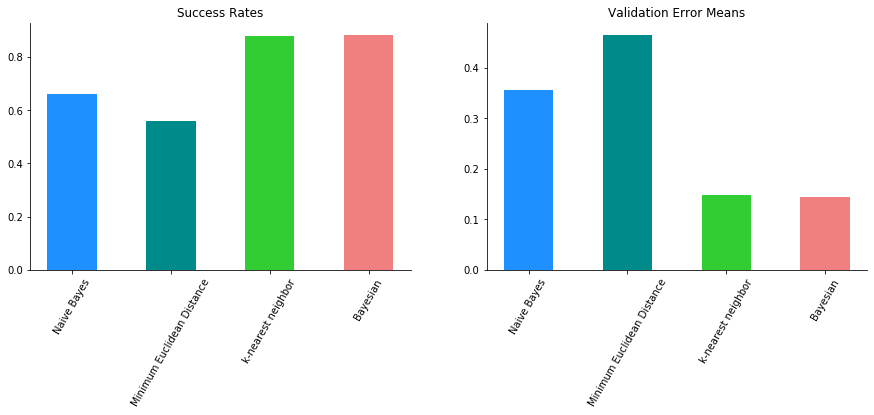

In [189]:
ve = [validation_NB[0], validation_mdc[0], validation_knn[0], validation_bayes[0]]

top=[ ('Naive Bayes',sr_NB)
     ,('Minimum Euclidean Distance',sr_MD)
     ,('k-nearest neighbor',sr_knn)
     ,('Bayesian',sr_by)
    ]

lab, ys = zip(*top)
xs = np.arange(len(lab)) 
width = 0.5

fig = plt.figure(figsize=(15,10))                                                               
ax = fig.add_subplot(221)

ax.bar(xs, ys, width, align='center', color=colors)
ax.set_title('Success Rates')
ax.set_xticks(xs)
ax.set_xticklabels(lab, rotation=60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(222)
ax.bar(xs, ve, width, align='center', color=colors)
ax.set_title('Validation Error Means')
ax.set_xticks(xs)
ax.set_xticklabels(lab, rotation=60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

When evaluating the confusion matrices, the most diagonal ones are the better ones.
* Clearly the `minimum distance classifier` had the most missclassified pixels.
* Fairly better, the `Naive Bayes classifier` managed to reduce the amount of pixels missclassified, but still there were considerable amount of pixels that were classified wrongly.
* The `k-nn classifier`, performed very good, with the exception of a few classes.
* Lastly, the `Bayes classifier` managed to classify a good amount of pixels to the correct classes with a few exceptions.

All in all, the __Bayes classifier__ outperformed all the other methods as expected. This is logical, if we consider that this classifier is a powerfull parametric classifier, that estimates a great number of parameters, including the full covariance matrix of the data set.

The __k-nn classifier__ had also very good results. This proves that non-parametric models are powerfull, even though they don't make assumptions about the model that generated the data. The only drawback is that this method used a lot of computational power, and for bigger datasets that might be very costly.

The __Naive Bayes classifier__ performed fairly, with fewer amount of computations. The reason that it was outperformed by the Bayes classifier is that the features that we used were heavily correlated. The closer the spectral bands, the bigger the correlation. So, it is logical that this classifier did not perform very well under those assumptions.

The __Minimum Distance classifier__ had the worst results from all the other methods. It also had the most strict assumptions, it considered the classes equiprobable and with the same diagonal covariance matrix, but that is far from the truth. This classifier was not suited to solve the particular classification task due to the nature of the dataset.

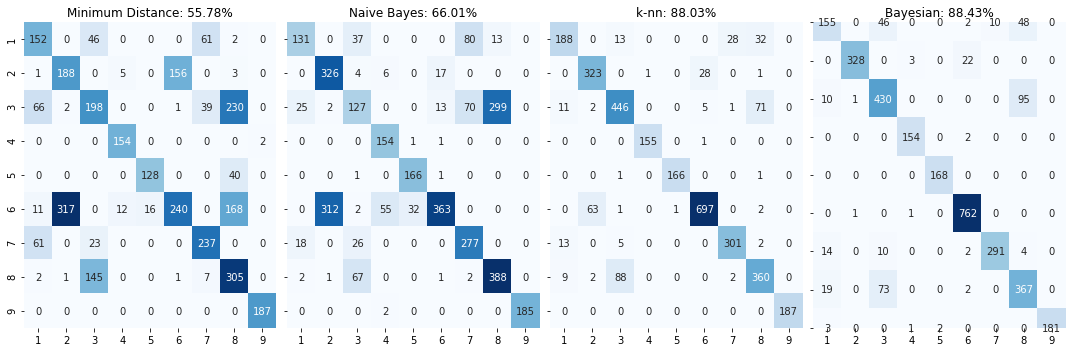

In [25]:
import seaborn as sn
import pandas as pd

def to_perc(a):
    return ": {0:.2%}".format(a) #str(100*np.round(a,2))

df_NB = pd.DataFrame(cm_NB, index = [i for i in "123456789"],columns = [i for i in "123456789"])
df_MD = pd.DataFrame(cm_MD, index = [i for i in "123456789"],columns = [i for i in "123456789"])
df_knn = pd.DataFrame(cm_knn, index = [i for i in "123456789"],columns = [i for i in "123456789"])
df_BY = pd.DataFrame(cm_by, index = [i for i in "123456789"],columns = [i for i in "123456789"])

fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

sn.heatmap(df_MD, annot=True,cmap='Blues', fmt='d',cbar=None,ax = axs[0])
axs[0].set_title('Minimum Distance'+ to_perc(sr_MD))

sn.heatmap(df_NB, annot=True,cmap='Blues', fmt='d',cbar=None,ax = axs[1])
axs[1].set_title('Naive Bayes'+ to_perc(sr_NB) )

sn.heatmap(df_knn, annot=True,cmap='Blues', fmt='d',cbar=None,ax = axs[2])
axs[2].set_title('k-nn'+ to_perc(sr_knn))

sn.heatmap(df_BY, annot=True,cmap='Blues', fmt='d',cbar=None,ax = axs[3])
axs[3].set_title('Bayesian'+ to_perc(sr_by))
fig.tight_layout()

plt.show()

## Part 3 -  Combination

When we performed spectral unmixing on the image, we observed that a few materials were not unmixed very well. Especially `materials 3 & 8` .
If we look at the confusion matrix of the `Bayes classifier`, which had the best results, we observe that a lot of pixels were missclassified between `materials 3 & 8` as well.

That is logical, if we consider that their spectral signatures were almost identical. That means that the datasets stemmed from those two classes, were not easily separated. That led to unmixing errors and also classification errors as well.